In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import torch
import torch.nn as nn
import torch.optim as optim

import matplotlib.pyplot as plt

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/deeplearningbrov2/pytorch/data/kospi.csv")

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,2183.489990,2206.199951,2177.879883,2206.199951,2206.199951,480400
1,2019-01-31,2222.879883,2222.879883,2201.219971,2204.850098,2204.850098,545200
2,2019-02-01,2211.929932,2218.780029,2201.409912,2203.459961,2203.459961,479400
3,2019-02-07,2215.770020,2215.790039,2196.770020,2203.419922,2203.419922,427800
4,2019-02-08,2192.010010,2192.479980,2171.959961,2177.050049,2177.050049,391000


In [ ]:
scaler = MinMaxScaler()
df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']] = scaler.fit_transform(df[['Open',
                                                                                       'High', 'Low', 'Close', 'Adj Close', 'Volume']])

In [ ]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-30,0.722898,0.732351,0.745525,0.759235,0.759235,0.242113
1,2019-01-31,0.763058,0.750069,0.769089,0.757866,0.757866,0.274771
2,2019-02-01,0.751894,0.745714,0.769280,0.756456,0.756456,0.241609
3,2019-02-07,0.755809,0.742538,0.764596,0.756415,0.756415,0.215603
4,2019-02-08,0.731584,0.717777,0.739548,0.729669,0.729669,0.197057


In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [ ]:
X = df[['Open', 'High', 'Low', 'Volume']].values
y = df['Close'].values

In [ ]:
def seq_data(x, y, sequence_length):
  x_seq = []
  y_seq = []
  for i in range(len(x)-sequence_length):
    x_seq.append(x[i:i+sequence_length])
    y_seq.append(y[i+sequence_length])

  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])

In [ ]:
split = 200
sequence_length = 5 #5일의 데이터를 보고 다음 날을 예측

x_seq, y_seq = seq_data(X, y, sequence_length)

x_train_seq = x_seq[:split]
y_train_seq = y_seq[:split]
x_test_seq = x_seq[split:]
y_test_seq = y_seq[split:]

/tmp/ipython-input-213502626.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.FloatTensor(x_seq).to(device), torch.FloatTensor(y_seq).to(device).view([-1, 1])


In [ ]:
train = torch.utils.data.TensorDataset(x_train_seq, y_train_seq)
test = torch.utils.data.TensorDataset(x_test_seq, y_test_seq)

batch_size = 20
train_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(test, batch_size=batch_size, shuffle=False)

###하이퍼파라미터 설정

In [ ]:
#RNN, LSTM same
input_size = x_seq.size(2)
num_layers = 2
hidden_size = 8

###RNN을 활용한 주가 예측

In [ ]:
class LSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(LSTM, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) #lstm 파이토치에서 제공
    self.fc = nn.Sequential(nn.Linear(hidden_size*sequence_length, 1), nn.Sigmoid())

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #초기 은닉층 설정
    c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #초기 셀 스테이트 설정
    out, _ = self.lstm(x,(h0, c0)) #RNN의 마지막 레이어로부터 나온 output feature 반환, hn : hidden state 반환
    out = out.reshape(out.shape[0], -1) #many to many 전략
    out = self.fc(out)
    return out

In [ ]:
model = LSTM(input_size = input_size,
                   hidden_size = hidden_size,
                   num_layers = num_layers,).to(device)

In [ ]:
criterion = nn.MSELoss()

lr = 1e-3
num_epochs = 200
optimizer = optim.Adam(model.parameters(),lr=lr)

###모델 학습하기

In [ ]:
loss_graph = []
n = len(train_loader)

for epoch in range(num_epochs):
  running_loss = 0.0

  for data in train_loader:
    seq, target = data
    out = model(seq)
    loss = criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

  loss_graph.append(running_loss/n)

  if epoch % 100 == 0:
    print(f"epoch : {epoch}, loss : {running_loss/n}")

epoch : 0, loss : 0.02424599084770307
epoch : 100, loss : 0.0010548543010372668


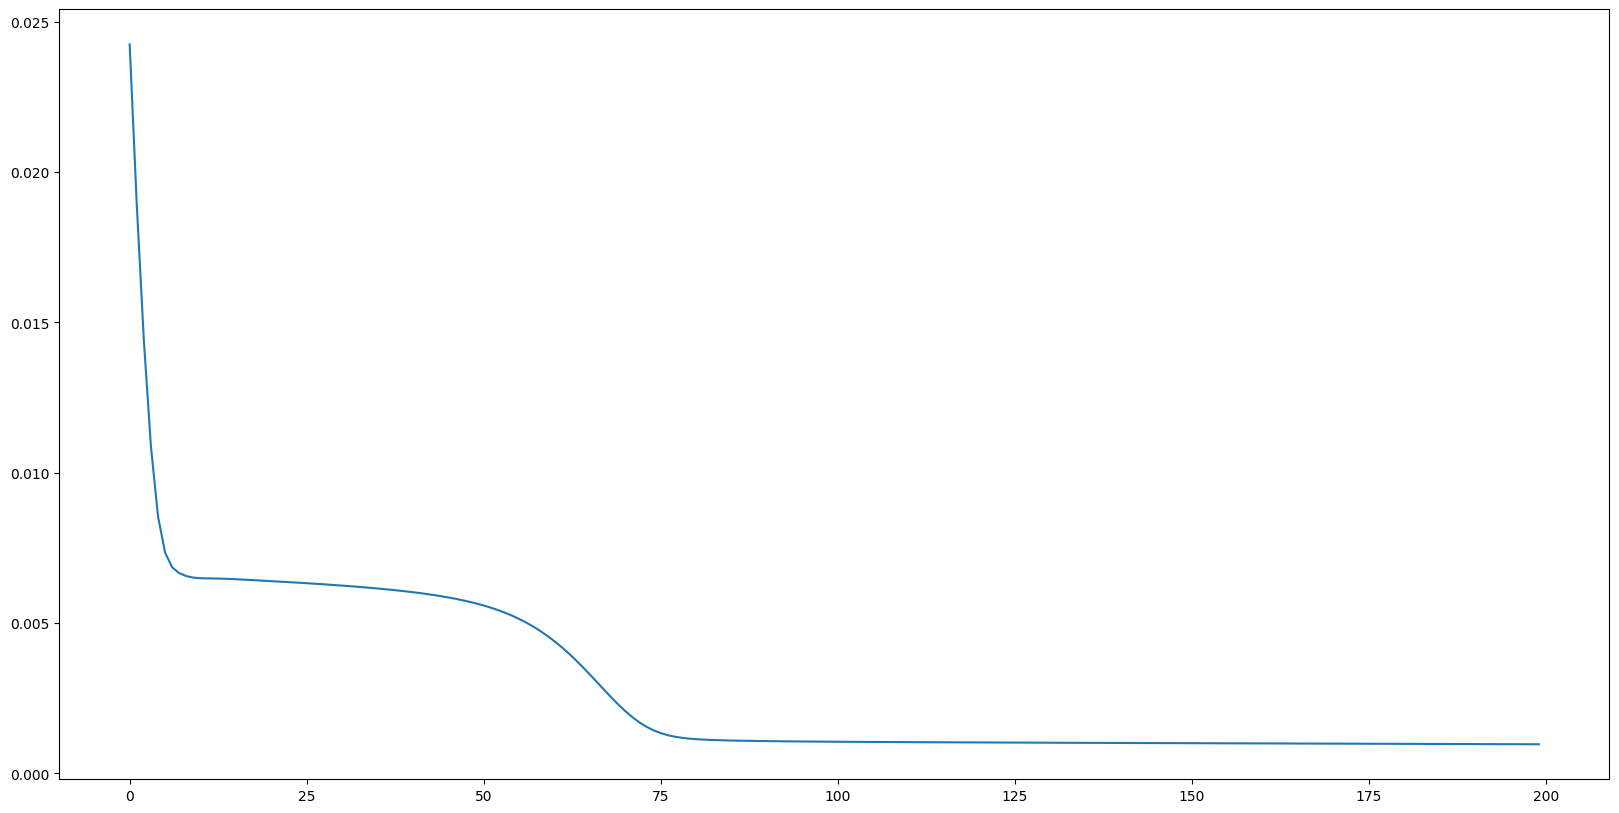

In [ ]:
plt.figure(figsize=(20, 10))
plt.plot(loss_graph)
plt.show()

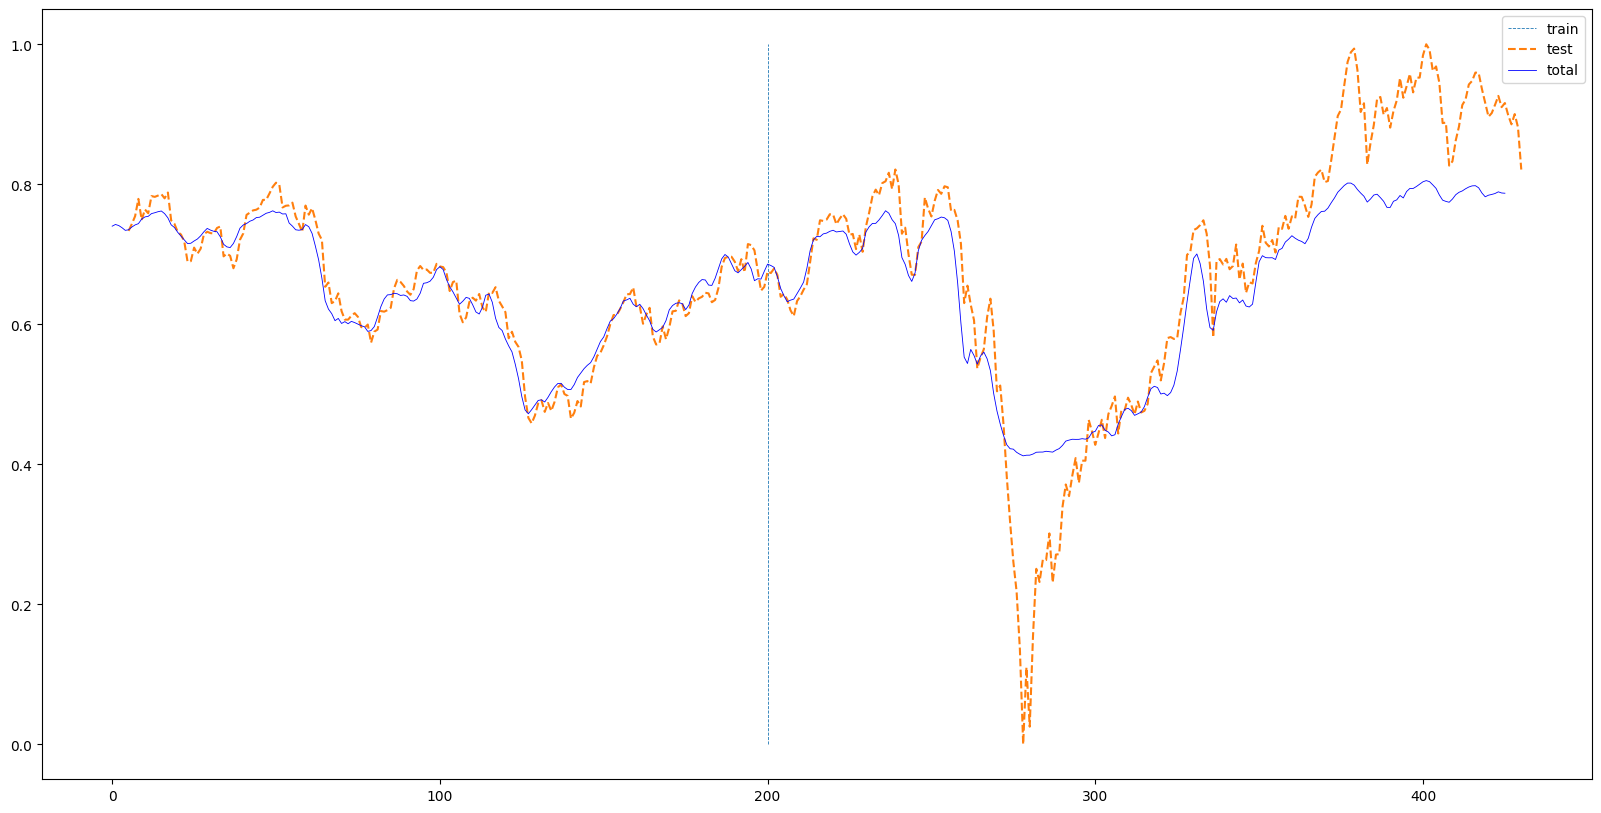

In [ ]:
def plotting (train_loader, test_loader, actual):
  with torch.no_grad():
    train_pred = []
    test_pred = []

    for data in train_loader:
      seq, target = data
      out = model(seq)
      train_pred += out.cpu().numpy().tolist()

    for data in test_loader:
      seq, target = data
      out = model(seq)
      test_pred += out.cpu().numpy().tolist()

  total = train_pred + test_pred
  plt.figure(figsize=(20, 10))
  plt.plot(np.ones(100)*len(train_pred), np.linspace(0,1,100), '--', linewidth = 0.6)
  plt.plot(actual, '--')
  plt.plot(total, 'b', linewidth=0.6)

  plt.legend(['train', 'test', 'total'])
  plt.show()

plotting(train_loader, test_loader, df['Close'][sequence_length:])

In [ ]:
#####GRU#####
class GRU(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers):
    super(GRU, self).__init__()
    self.device = device
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True) #lstm 파이토치에서 제공
    self.fc = nn.Linear(hidden_size*sequence_length, 1)

  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(self.device) #초기 은닉층 설정
    out, _ = self.gru(x,(h0)) #RNN의 마지막 레이어로부터 나온 output feature 반환, hn : hidden state 반환
    out = out.reshape(out.shape[0], -1) #many to many 전략
    out = self.fc(out)
    return out

#BiLSTM
LSTM 묘듈 두 개로 순방향과 역방향 연산을 모두 수행하게 하는 것

In [ ]:
#self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional = True)
#여기에 bidirectional = True 설정만 하면됨

lstm 두 개를 운용하기 때문에 레이어 수를 2배 해줘야함
*   이걸로 이미지 처리도 가능


